# Libraries & Settings

In [40]:
from utils import *
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split
from imblearn.under_sampling import RandomUnderSampler
from sklearn.metrics import make_scorer, matthews_corrcoef, confusion_matrix
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import classification_report
from sklearn.utils.class_weight import compute_class_weight

In [2]:
pd.set_option("display.max_columns", None)
pd.set_option("display.width", 1000)
pd.set_option("display.precision", 3)
sns.set({"figure.figsize": (10, 6)})
plt.style.use("tableau-colorblind10")
warnings.filterwarnings("ignore")

# Reading Dataset & First Observations

  *__Dataset Info:__*
The binary classification goal is to predict if the transaction is fraud  (variable Class).
  
The dataset contains transactions made by credit cards in September 2013 by European cardholders.

*__Dataset Link:__* https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud

*__Notes:__* This dataset presents transactions that occurred in two days, where we have 492 frauds out of 284,807 transactions. The dataset is highly unbalanced, the positive class (frauds) account for 0.172% of all transactions. It contains only numerical input variables which are the result of a PCA transformation. Unfortunately, due to confidentiality issues, dataset cannot provide the original features and more background information about the data. Features V1, V2, … V28 are the principal components obtained with PCA, the only features which have not been transformed with PCA are __Time__ and __Amount__.

*__Features:__*

1 - __Time:__ Number of seconds elapsed between this transaction and the first transaction in the dataset

2 - __V1,V2...V28:__  Those features are anonamised due to customer confidentiality, (all of them are numeric)

3- __Amount:__ Transaction amount

4- __Class:__ Target variable, 1 for fraudulent transactions, 0 otherwise 

In [3]:
fraud = pd.read_csv("dataset/creditcard.csv")
data = fraud.copy()

In [4]:
data.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.360,-0.073,2.536,1.378,-0.338,0.462,0.240,0.099,0.364,0.091,-0.552,-0.618,-0.991,-0.311,1.468,-0.470,0.208,0.026,0.404,0.251,-0.018,0.278,-0.110,0.067,0.129,-0.189,0.134,-0.021,149.62,0
1,0.0,1.192,0.266,0.166,0.448,0.060,-0.082,-0.079,0.085,-0.255,-0.167,1.613,1.065,0.489,-0.144,0.636,0.464,-0.115,-0.183,-0.146,-0.069,-0.226,-0.639,0.101,-0.340,0.167,0.126,-0.009,0.015,2.69,0
2,1.0,-1.358,-1.340,1.773,0.380,-0.503,1.800,0.791,0.248,-1.515,0.208,0.625,0.066,0.717,-0.166,2.346,-2.890,1.110,-0.121,-2.262,0.525,0.248,0.772,0.909,-0.689,-0.328,-0.139,-0.055,-0.060,378.66,0
3,1.0,-0.966,-0.185,1.793,-0.863,-0.010,1.247,0.238,0.377,-1.387,-0.055,-0.226,0.178,0.508,-0.288,-0.631,-1.060,-0.684,1.966,-1.233,-0.208,-0.108,0.005,-0.190,-1.176,0.647,-0.222,0.063,0.061,123.50,0
4,2.0,-1.158,0.878,1.549,0.403,-0.407,0.096,0.593,-0.271,0.818,0.753,-0.823,0.538,1.346,-1.120,0.175,-0.451,-0.237,-0.038,0.803,0.409,-0.009,0.798,-0.137,0.141,-0.206,0.502,0.219,0.215,69.99,0


In [5]:
dataset_summary(data)

##################### Shape #####################
(284807, 31)
##################### Info #####################
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     2848

In [6]:
data.duplicated().sum()

1081

In [7]:
data.loc[data.duplicated(keep=False), :]

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
32,26.0,-0.530,0.874,1.347,0.145,0.414,0.100,0.711,0.176,-0.287,-0.485,0.872,0.852,-0.572,0.101,-1.520,-0.284,-0.311,-0.404,-0.823,-0.290,0.047,0.208,-0.186,1.031e-03,0.099,-0.553,-0.073,0.023,6.14,0
33,26.0,-0.530,0.874,1.347,0.145,0.414,0.100,0.711,0.176,-0.287,-0.485,0.872,0.852,-0.572,0.101,-1.520,-0.284,-0.311,-0.404,-0.823,-0.290,0.047,0.208,-0.186,1.031e-03,0.099,-0.553,-0.073,0.023,6.14,0
34,26.0,-0.535,0.865,1.351,0.148,0.434,0.087,0.693,0.180,-0.286,-0.482,0.872,0.853,-0.572,0.102,-1.520,-0.286,-0.310,-0.404,-0.824,-0.283,0.050,0.207,-0.187,7.530e-04,0.098,-0.553,-0.078,0.025,1.77,0
35,26.0,-0.535,0.865,1.351,0.148,0.434,0.087,0.693,0.180,-0.286,-0.482,0.872,0.853,-0.572,0.102,-1.520,-0.286,-0.310,-0.404,-0.824,-0.283,0.050,0.207,-0.187,7.530e-04,0.098,-0.553,-0.078,0.025,1.77,0
112,74.0,1.038,0.127,0.184,1.110,0.442,0.945,-0.037,0.351,0.119,-0.243,0.578,0.675,-0.534,0.447,1.123,-1.768,1.241,-2.449,-1.747,-0.336,0.103,0.605,0.023,-6.265e-01,0.479,-0.167,0.081,0.001,1.18,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
283485,171627.0,-1.458,1.378,0.812,-0.604,-0.712,-0.472,-0.283,0.881,0.053,-0.831,-1.192,0.943,1.373,-0.038,-0.208,0.322,-0.206,-0.025,-0.468,0.024,0.284,0.950,-0.217,8.325e-02,0.045,0.640,0.219,0.117,11.93,0
284190,172233.0,-2.668,3.161,-3.356,1.008,-0.377,-0.110,-0.667,2.310,-1.639,-1.450,-0.509,0.600,-0.627,1.017,-0.887,0.420,1.856,1.315,1.096,-0.822,0.391,0.267,-0.080,-9.640e-02,0.087,-0.451,-1.184,-0.222,55.66,0
284191,172233.0,-2.668,3.161,-3.356,1.008,-0.377,-0.110,-0.667,2.310,-1.639,-1.450,-0.509,0.600,-0.627,1.017,-0.887,0.420,1.856,1.315,1.096,-0.822,0.391,0.267,-0.080,-9.640e-02,0.087,-0.451,-1.184,-0.222,55.66,0
284192,172233.0,-2.692,3.123,-3.339,1.017,-0.293,-0.167,-0.746,2.326,-1.635,-1.440,-0.512,0.608,-0.628,1.023,-0.888,0.413,1.860,1.317,1.095,-0.791,0.403,0.260,-0.087,-9.760e-02,0.084,-0.454,-1.205,-0.213,36.74,0


In [8]:
data.drop_duplicates(inplace=True)

# EDA & Visualizations

In [9]:
cat_summary(data,"Class")

        Class   Ratio
Class                
0      283253  99.833
1         473   0.167


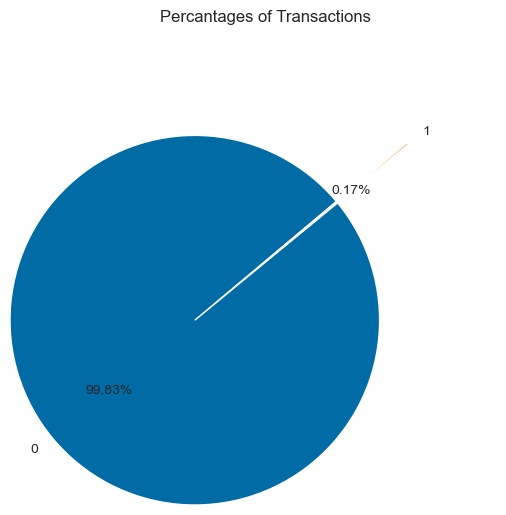

In [10]:
temp = data['Class'].value_counts()
explode = (0.5, 0)
plt.pie(temp, labels=temp.index, autopct='%1.2f%%', explode=explode, startangle=40)
plt.title("Percantages of Transactions");

*as you can see, dataset is highly inbalanced*

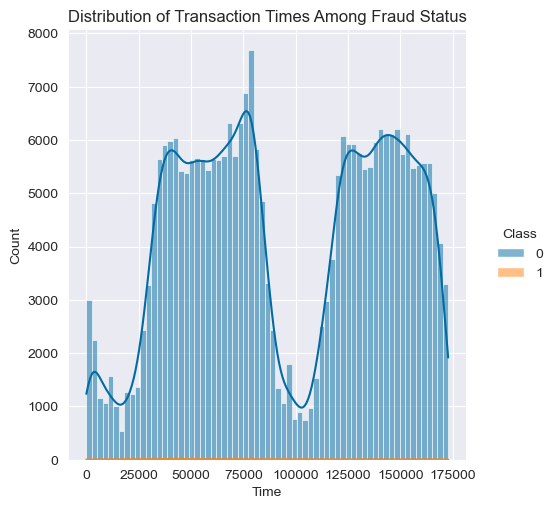

In [11]:
sns.displot(data=data, x="Time", kde=True, hue="Class");
plt.title("Distribution of Transaction Times Among Fraud Status");

(0.0, 25691.16)

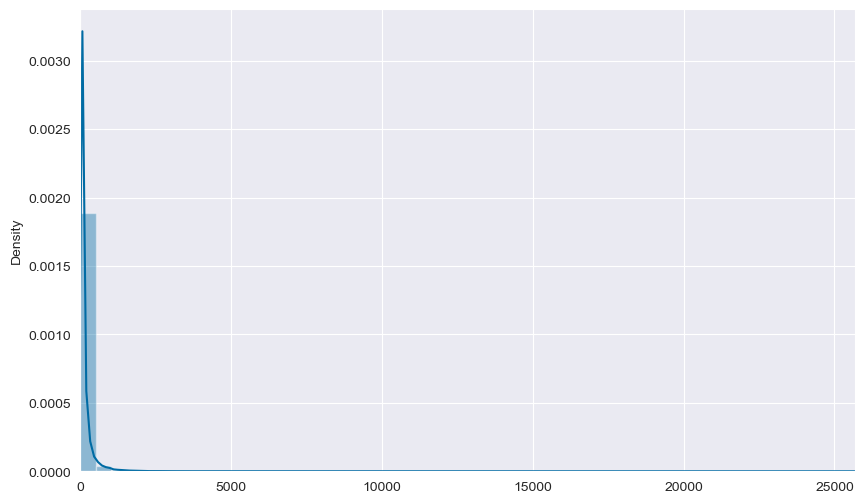

In [12]:
amount_val = data["Amount"].values
sns.distplot(amount_val)
plt.xlim([data["Amount"].min(), data["Amount"].max()])

*since we dont have any info or domain knowledge about anonimized columns, there's no chance to do feature engineering, so i'm directly moving to preprocessing stage*

# Preprocessing

In [13]:
scaler = RobustScaler()

*i've decided to use RobustScaler because it is less prone to outliers*
 
*Note: Scaling PCA features is not necessary, because they're already scaled as you can see in first obs. section *

In [14]:
data["Time"] = scaler.fit_transform(data["Time"].values.reshape(-1, 1)) # scalers expects 2-d data
data["Amount"] = scaler.fit_transform(data["Amount"].values.reshape(-1, 1))

## Splitting Dataset

In [15]:
X = data.drop("Class", axis=1)
y = data["Class"]

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42,shuffle=True,stratify=y)

In [17]:
y_train.value_counts()

Class
0    226602
1       378
Name: count, dtype: int64

In [18]:
y_test.value_counts()

Class
0    56651
1       95
Name: count, dtype: int64

*it's been stratified well, now i want to use undersampling for dealing imbalance*

## Undersampling

In [19]:
rus = RandomUnderSampler(random_state=42)
X_resampled, y_resampled = rus.fit_resample(X_train, y_train)    

In [20]:
print("Distrubition of class after undersampling:", np.bincount(y_resampled))

Distrubition of class after undersampling: [378 378]


# Model Selection & Hyper-parameter Optimization

In [21]:
mcc_scorer = make_scorer(matthews_corrcoef) #i'm using this for scoring metric because in this problem accuracy is not optimal performance metric

In [23]:
best_models = hyperparameter_optimization(X=X_resampled, y=y_resampled,models=classifiers,cv=5,scoring=mcc_scorer)

Hyperparameter Optimization....
##########Logistic Regression##########
MCC (Before): 0.866296068690179
MCC (After): 0.8775894051593124
Logistic Regression best params: {'C': 1, 'penalty': 'l2', 'solver': 'saga'}

##########Decision Tree##########
MCC (Before): 0.8283489772909072
MCC (After): 0.8472423752429311
Decision Tree best params: {'criterion': 'gini', 'max_depth': 3, 'min_samples_leaf': 4}

##########Random Forest##########
MCC (Before): 0.8711979859794126
MCC (After): 0.8760765452036097
Random Forest best params: {'max_depth': None, 'max_features': 7, 'min_samples_leaf': 1, 'n_estimators': 250}

##########Gradient Boosting##########
MCC (Before): 0.872185302914407
MCC (After): 0.8750146391586838
Gradient Boosting best params: {'learning_rate': 0.2, 'max_depth': 5, 'n_estimators': 250}

##########Ada Boosting##########
MCC (Before): 0.8586019788169444
MCC (After): 0.8877344748915998
Ada Boosting best params: {'algorithm': 'SAMME', 'estimator': None, 'learning_rate': 0.350000000

Text(0, 0.5, 'MCC Score')

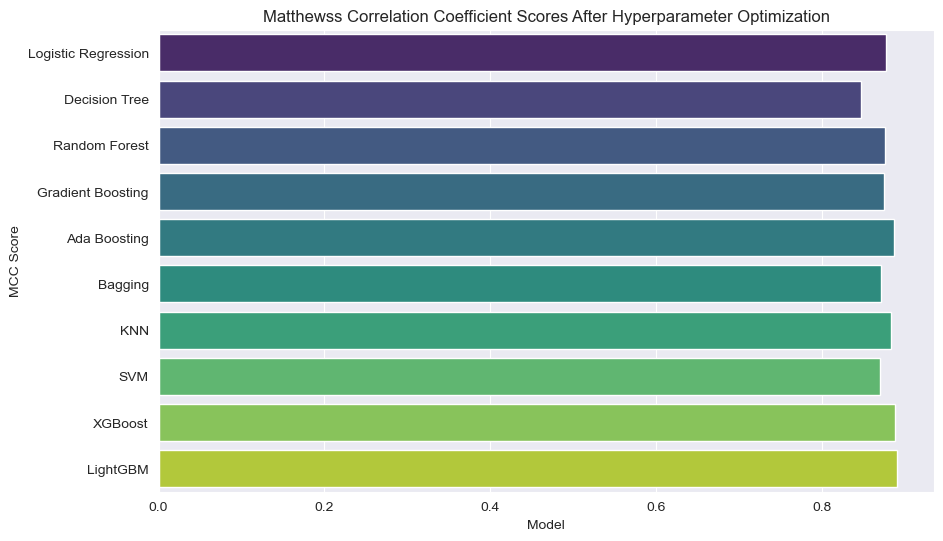

In [24]:
df = pd.DataFrame(best_models).transpose()
sns.barplot(data=df, x="MCC", y=df.index, palette="viridis")
plt.title("Matthews Correlation Coefficient Scores After Hyperparameter Optimization")
plt.xlabel("Model")
plt.ylabel("MCC Score")

In [29]:
top_models = sorted(best_models.values(), key=lambda x: x["MCC"], reverse=True)[:5]
voting_model = VotingClassifier(estimators=[
    ("1st", top_models[0]["Model"]),
    ("2nd", top_models[1]["Model"]),
    ("3rd", top_models[2]["Model"]),
    ("4th", top_models[3]["Model"]),
    ("5th", top_models[4]["Model"]),
], voting="soft")

In [30]:
voting_model.fit(X_resampled, y_resampled)

VotingClassifier(estimators=[('1st',
                              LGBMClassifier(max_depth=4, n_estimators=400,
                                             verbose=-1)),
                             ('2nd',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_metric='logloss',
                                            feature_types=None, gamma=None,
                                            grow_poli...
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=250, n_jobs=None,
                                            num_parallel_tree=None,
                                            random_state=None, ...)),
                             ('3rd',
                              AdaBoostClassifier(algorithm='SAMME',
                                                 learning_rate=0.35000000000000003,
                                                 n_estimators=350)),
                             ('4th',
                              KNeighborsClassifier(metric='manhattan',
                                                   n_neighbors=4)),
                             ('5th', LogisticRegression(C=1, solver='saga'))],
                 voting='soft')

In [31]:
predictions = voting_model.predict(X_test)

In [32]:
print(classification_report(y_test,predictions))

              precision    recall  f1-score   support

           0       1.00      0.98      0.99     56651
           1       0.06      0.87      0.12        95

    accuracy                           0.98     56746
   macro avg       0.53      0.93      0.55     56746
weighted avg       1.00      0.98      0.99     56746



In [33]:
roc_auc = roc_auc_score(y_test, voting_model.predict_proba(X_test)[:, 1])
mcc_score = matthews_corrcoef(y_test, predictions)

In [35]:
print("ROC-AUC Score:",roc_auc)

ROC-AUC Score: 0.9710478469744113


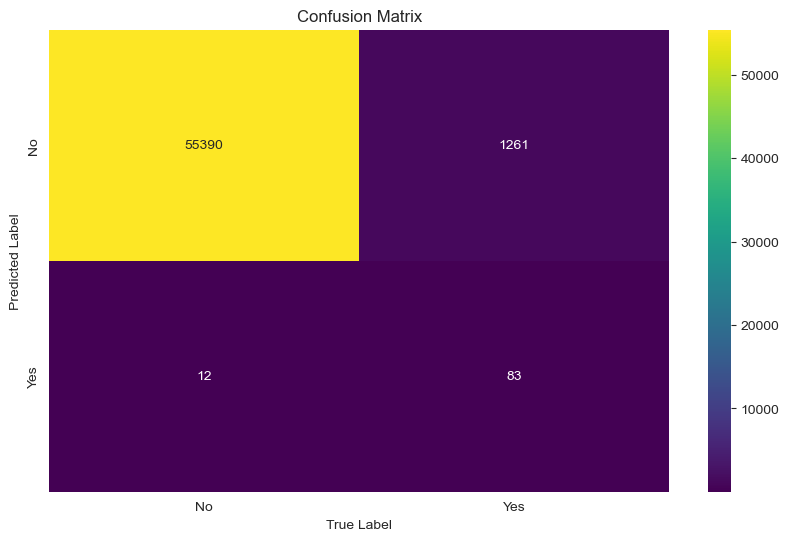

In [38]:
cm = confusion_matrix(y_test, predictions)
sns.heatmap(cm, annot=True, fmt="d", cmap="viridis", xticklabels=["No", "Yes"], yticklabels=["No", "Yes"])
plt.title("Confusion Matrix")
plt.ylabel("Predicted Label")
plt.xlabel("True Label");

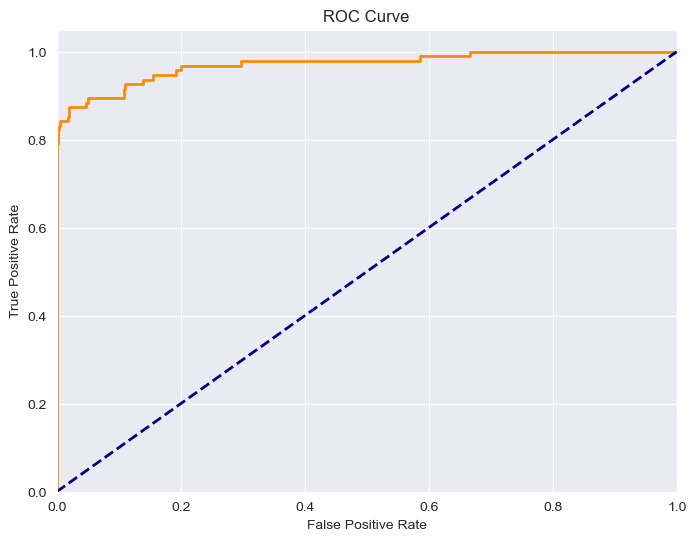

In [39]:
plot_roc_curve(voting_model, X_test, y_test)

# Adjusting Class Weights

In [42]:
class_weights = compute_class_weight("balanced", classes=np.unique(y_train), y=y_train)
class_weight_dict = dict(zip(np.unique(y_train), class_weights))

In [47]:
print(class_weight_dict)

{0: 0.5008340614822464, 1: 300.23809523809524}


In [43]:
model = RandomForestClassifier(class_weight=class_weight_dict, max_depth = None,n_estimators=250)

In [44]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [45]:
cv_results = cross_val_score(model, X_train, y_train,cv=skf, scoring=mcc_scorer)

In [46]:
print(cv_results)
print("Average CV Score:", cv_results.mean())

[0.82497534 0.87209748 0.76989713 0.84693824 0.88360506]
Average CV Score: 0.839502648715359


In [48]:
model.fit(X_train, y_train)

RandomForestClassifier(class_weight={0: 0.5008340614822464,
                                     1: 300.23809523809524},
                       n_estimators=250)

In [49]:
predictions = model.predict(X_test)

In [50]:
print(classification_report(y_test,predictions))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56651
           1       0.99      0.71      0.82        95

    accuracy                           1.00     56746
   macro avg       0.99      0.85      0.91     56746
weighted avg       1.00      1.00      1.00     56746



In [56]:
roc_auc = roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])
mcc_score = matthews_corrcoef(y_test, predictions)

In [57]:
print("ROC-AUC Score:",roc_auc)
print("MCC Score:",mcc_score)

ROC-AUC Score: 0.943820845825177
MCC Score: 0.833382171603196


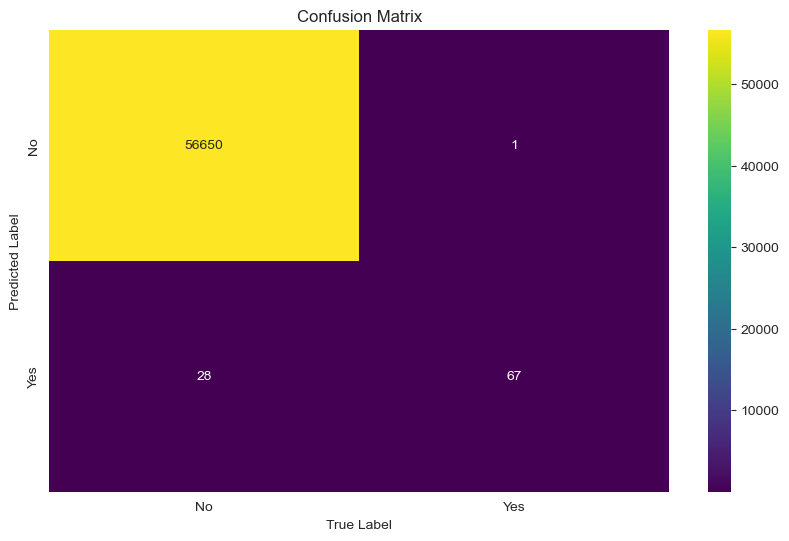

In [53]:
cm = confusion_matrix(y_test, predictions)
sns.heatmap(cm, annot=True, fmt="d", cmap="viridis", xticklabels=["No", "Yes"], yticklabels=["No", "Yes"])
plt.title("Confusion Matrix")
plt.ylabel("Predicted Label")
plt.xlabel("True Label");